In [6]:
%load_ext autoreload
%autoreload 2

In [14]:
import os
import pickle
import sys
from pathlib import Path

import lab.torch as B
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from wbml import plot
import tueplots

# torch.set_printoptions(precision=8, sci_mode=False, edgeitems=5)
torch.set_printoptions(profile='full') # 'short'

colors = sns.color_palette("bright")
sns.set_style("whitegrid")
sns.set_palette(colors)

matplotlib.rcParams["figure.dpi"] = 300  # for high quality, retina plots

from tueplots import bundles, fontsizes, figsizes


from wbml import experiment, out, plot

In [81]:

gvi_exps = {}
seq_exps = {}
sync_exps = {}

gvi_exps['mfvi'] = 'draft_results/Bank/GVI/07-24-13.54.22_seq-mfvi-bank-1c-10g-1000l-nealprior-128b-0-02lr-2s-gvi'
gvi_exps['gi'] =  'draft_results/Bank/GVI/07-24-14.48.55_seq-pvi-bank-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m'

seq_exps['mfvi'] = 'draft_results/Bank/Seq/07-24-13.21.51_seq-mfvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s'
seq_exps['gi'] =  'draft_results/Bank/Seq/07-24-13.01.24_seq-pvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m'

sync_exps['mfvi'] = 'draft_results/Bank/Sync/07-24-16.00.58_sync-mfvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s'
sync_exps['gi'] = 'draft_results/Bank/Sync/07-24-14.47.22_sync-pvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m'

bank_exps = {'seq': seq_exps, 'sync': sync_exps, 'gvi': gvi_exps}

In [82]:

seq_exps = {'mfvi': "draft_results/Adult/Seq/07-24-10.12.05_seq-mfvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-equaltogi", 
                'gi': "draft_results/Adult/Seq/07-24-10.11.10_seq-pvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m-project-tight"}

sync_exps = {'mfvi': "draft_results/Adult/Sync/07-24-12.41.48_sync-mfvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s", 
                'gi': "draft_results/Adult/Sync/07-24-12.41.02_sync-pvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m"}

gvi_exps = {'mfvi':"draft_results/Adult/GVI/07-24-13.50.19_sync-mfvi-adult-1c-10g-1000l-nealprior-128b-0-02lr-2s-gvi", 
                'gi':"draft_results/Adult/GVI/07-24-14.46.53_seq-pvi-adult-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m-gvi"}

adult_exps = {'seq': seq_exps, 'sync': sync_exps, 'gvi': gvi_exps}

In [83]:
dataset = "Bank"
split = "A"
exps = bank_exps

omit_sync_mfvi = True

In [84]:
for v, exp in exps.items():
    for k, e in exp.items():
        main_dir = os.path.dirname(os.path.abspath(os.getcwd()))
        exp[k] = os.path.join(main_dir, e, "metrics")

In [85]:
pvi_setting = "PVI"
variational_method = "Method"
client_name = "Client"
logs = {}
for v, exp in exps.items():
    logs[v] = {}
    for k, e in exp.items():
        logs[v][k] = {}
        for log_name in os.listdir(e):
            
            name = log_name.split('_')[0]
            logs[v][k][name] = pd.read_csv(os.path.join(e, log_name))
            
            logs[v][k][name][pvi_setting] = v.upper()
            logs[v][k][name][variational_method] = k.upper()
            if name != 'server':
                logs[v][k][name][client_name] = name


Merge dataframes for plotting purposes.

In [86]:
clients = []
for v, exp in logs.items():
    for k, e in exp.items():
        for name, log in e.items():
            if name != 'server': clients.append(log)

client = pd.concat(clients, ignore_index=True)

In [87]:
servers = []
for v, exp in logs.items():
    for k, e in exp.items():
        servers.append(e['server'])

server = pd.concat(servers, ignore_index=True)

Plot test mll and accuracy

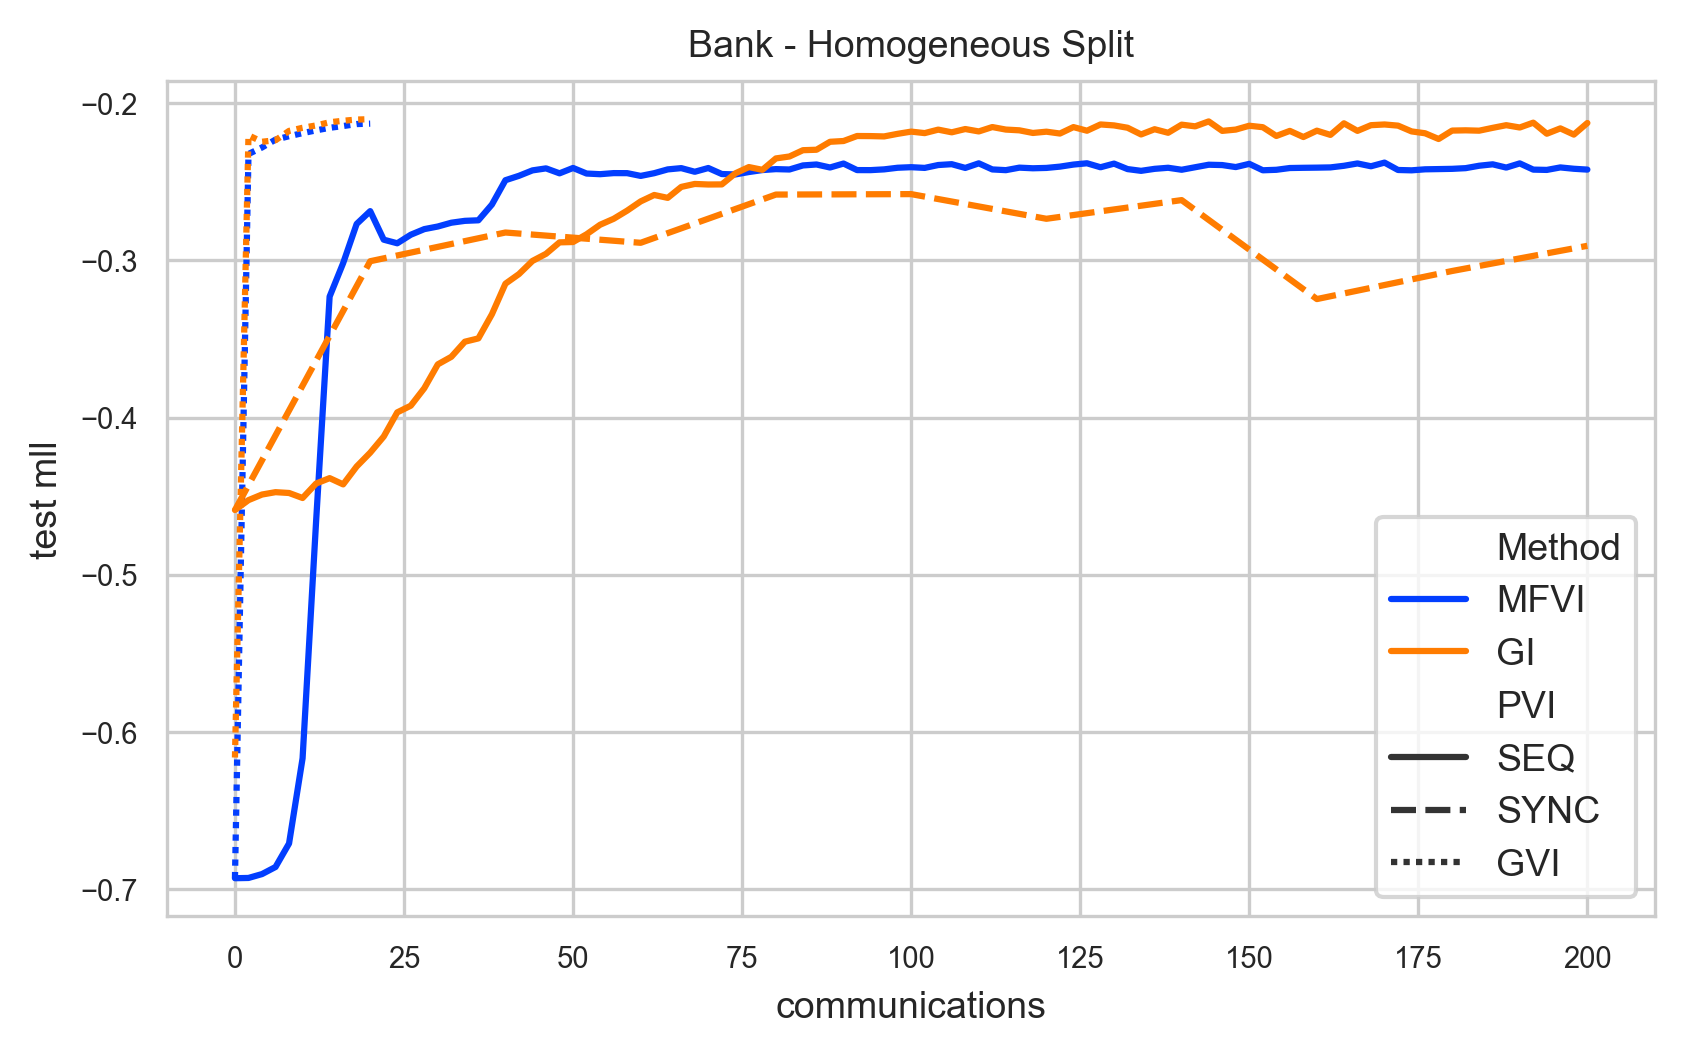

In [90]:
with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)
    if omit_sync_mfvi:
        data = server.loc[(server[pvi_setting] != 'SYNC') | (server[variational_method] != 'MFVI')]
    else:
        data = server
    
    x_metric = 'communications'
    y_metric = 'test_mll'
    
    sns.lineplot(data=data, x=x_metric, y=y_metric, ax=ax, hue=variational_method, style=pvi_setting)
    
    ax.set_title(f'{dataset} - Homogeneous Split')    
    ax.set_ylabel(' '.join(y_metric.split('_')))
    ax.set_xlabel(' '.join(x_metric.split('_')))
    ax.legend(loc="lower right", prop={"size": 9})

    file_name = f"./imgs/{split}_{dataset}_server_{x_metric}_{y_metric}"
    if omit_gvi_mfvi: file_name += "_omit_mfvi_gvi"

    plt.savefig(file_name)
    plt.show()

Accuracy

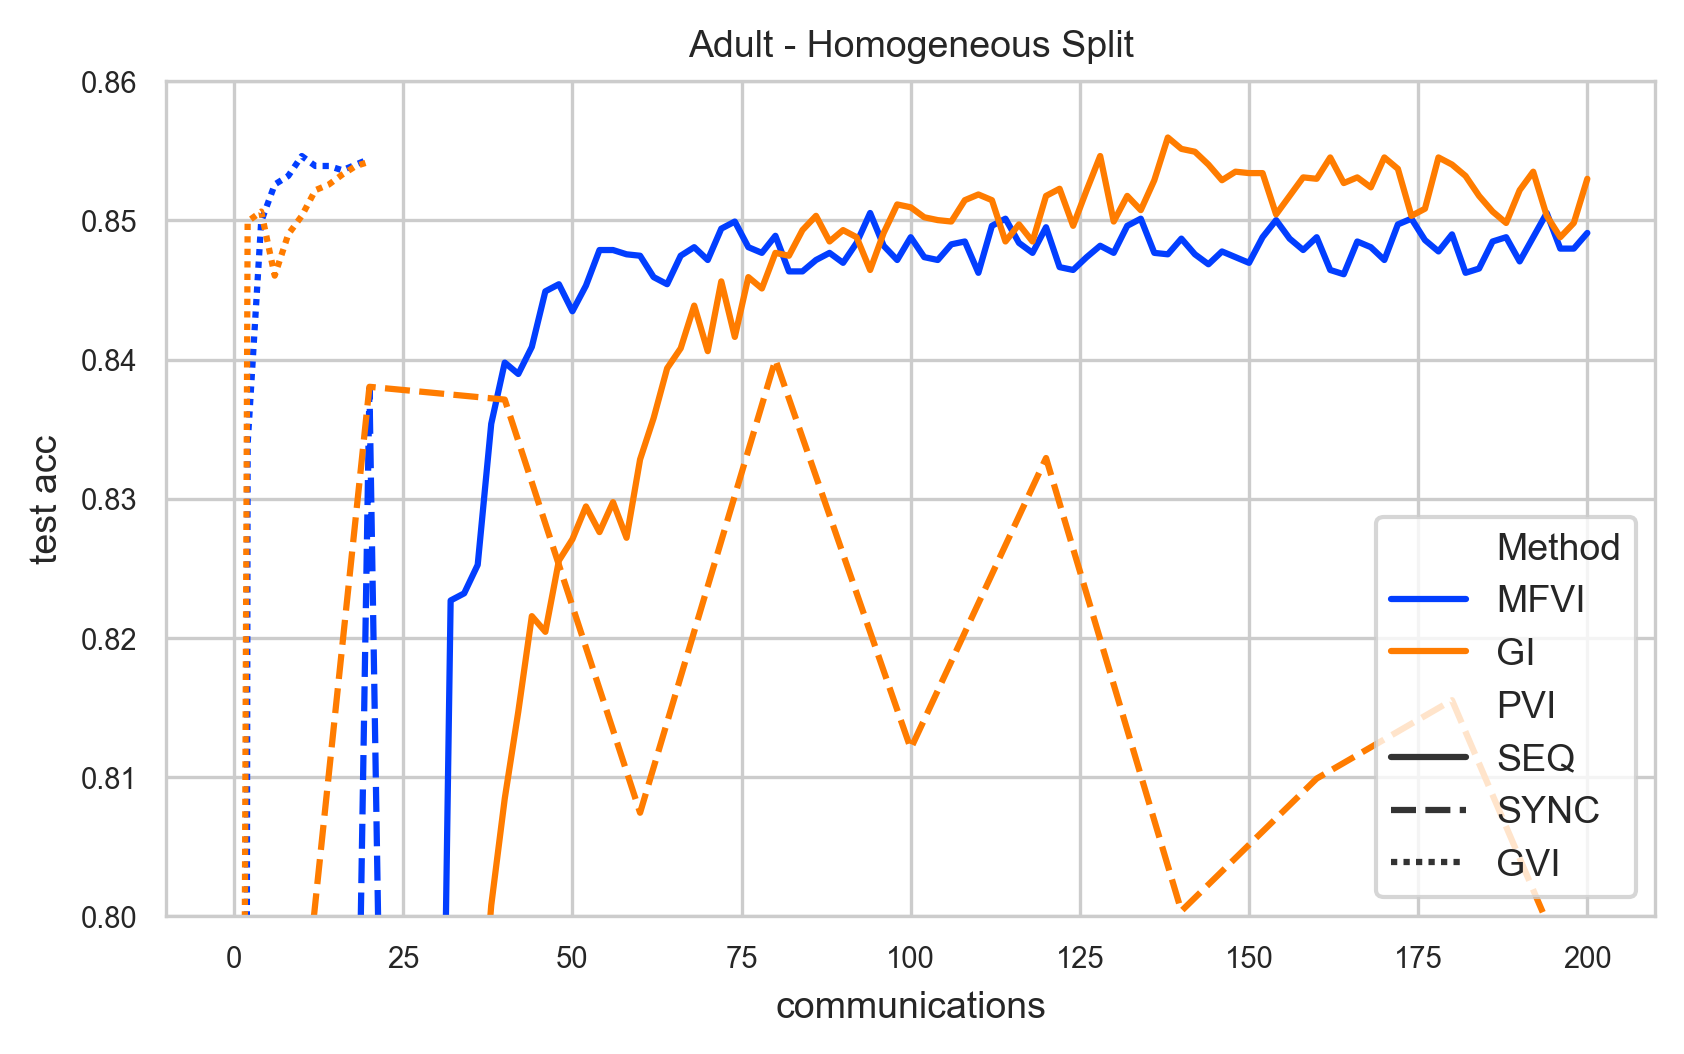

In [61]:
with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)

    x_metric = 'communications'
    y_metric = 'test_acc'
    sns.lineplot(data=server, x=x_metric, y=y_metric, ax=ax, hue=variational_method, style=pvi_setting)
    
    ax.set_title(f'{dataset} - Homogeneous Split')
    ax.set_ylim((0.80, 0.86))
    ax.set_ylabel(' '.join(y_metric.split('_')))
    ax.set_xlabel(' '.join(x_metric.split('_')))
    ax.legend(loc="lower right", prop={"size": 9})
    plt.savefig(f"./imgs/{split}_{dataset}_server_{x_metric}_{y_metric}")
    plt.show()

In [40]:
client

,global_iteration,local_iteration,total_iteration,vfe,ll,kl,error,PVI,Method,Client
0,4,0,4000,-4.003162,-0.683145,12971.306641,0.265625,SEQ,MFVI,client4
1,4,49,4049,-3.898394,-0.680459,12572.474609,0.257812,SEQ,MFVI,client4
2,4,99,4099,-3.861374,-0.679023,12433.444336,0.257812,SEQ,MFVI,client4
3,4,149,4149,-3.846992,-0.679876,12373.923828,0.289062,SEQ,MFVI,client4
4,4,199,4199,-3.835559,-0.676461,12342.595703,0.250000,SEQ,MFVI,client4
...,...,...,...,...,...,...,...,...,...,...
8815,9,799,9799,-0.338786,-0.326555,477.885986,0.140625,GVI,GI,client0
8816,9,849,9849,-0.296500,-0.284313,476.173584,0.125000,GVI,GI,client0
8817,9,899,9899,-0.365244,-0.352918,481.633392,0.179688,GVI,GI,client0
8818,9,949,9949,-0.273709,-0.261543,475.376068,0.101562,GVI,GI,client0


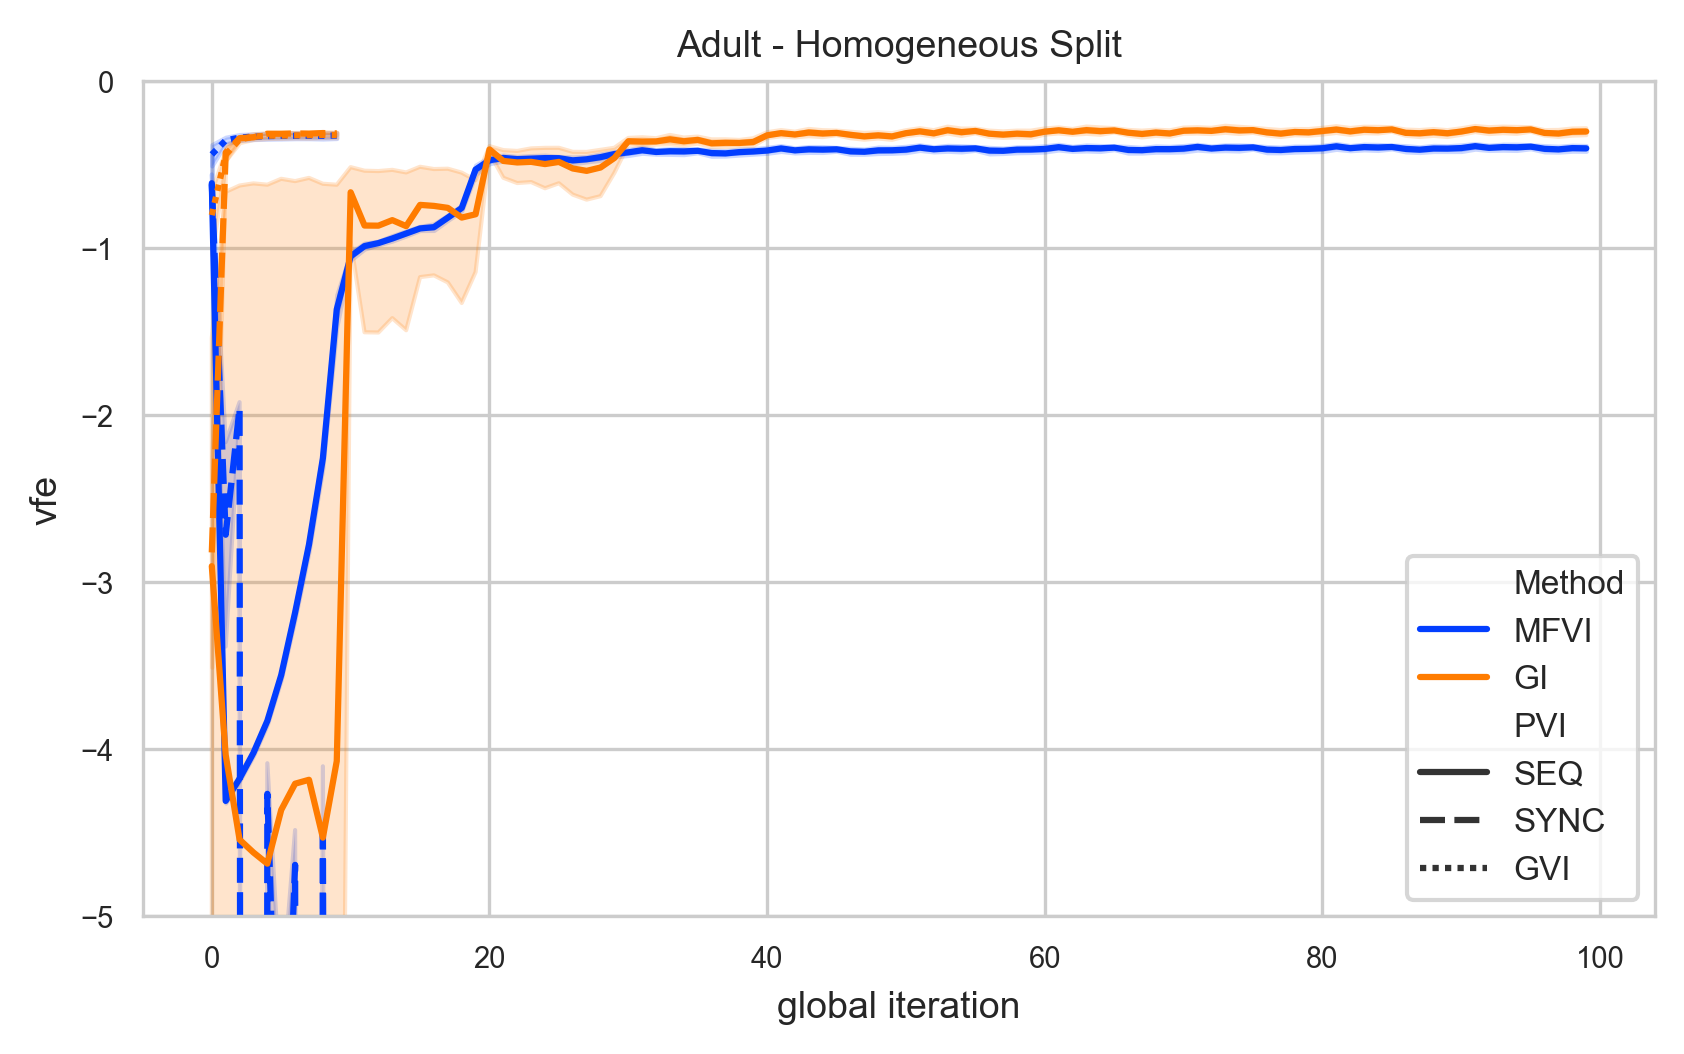

In [58]:
with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    y_metric = "vfe"
    x_metric = "global_iteration"
    fig, ax = plt.subplots(1, 1)

    sns.lineplot(data=client, x=x_metric, y=y_metric, ax=ax, hue=variational_method, style=pvi_setting)
    
    ax.set_title(f'{dataset} - Homogeneous Split')
    ax.set_ylim(-5, 0)
    ax.set_ylabel(' '.join(y_metric.split('_')))
    ax.set_xlabel(' '.join(x_metric.split('_')))
    ax.legend(loc="lower right", prop={"size": 8})
    plt.savefig(f"./imgs/{split}_{dataset}_client_{x_metric}_{y_metric}")
    plt.show()
